In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model = model.to('cuda:0') # switch cpu / gpu (cuda:0)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Downloading...
From: https://drive.google.com/uc?id=1VG4038s0Z5lvJ_99l--YMsM2KZg0FWaK
To: /content/img_dog.jpg
100% 10.2k/10.2k [00:00<00:00, 27.7MB/s]
torch.Size([1, 3, 224, 224])


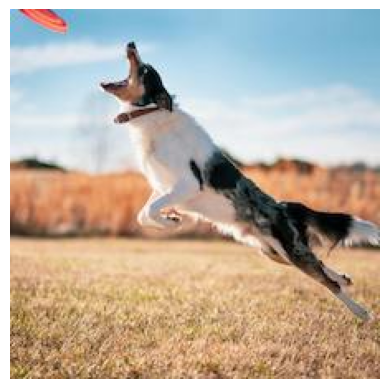

In [ ]:
# Different image download: https://drive.google.com/file/d/1HTm5iC6If3VObOHsiR_36Cwt8BqaFhMV/view?usp=sharing
!gdown 1VG4038s0Z5lvJ_99l--YMsM2KZg0FWaK
img = np.asarray(Image.open('/content/img_dog.jpg'))
imgplot = plt.imshow(img)
plt.axis('off')

# to PyTorch/ImageNet (dataset with 1000 classes) format
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])

img = transform(img) # transform to right format for model
img = img.to('cuda:0') # to cpu / gpu (cuda:0)
img = img.unsqueeze(0) # Shape 1,3,224,224 (Batch,Channel,Height,Weight)
print(img.shape)

In [ ]:
output = model(img)
print(output.shape)
prediction = output.argmax(dim=1)
print(prediction) # 232 = Border collie

torch.Size([1, 1000])
tensor([232], device='cuda:0')


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

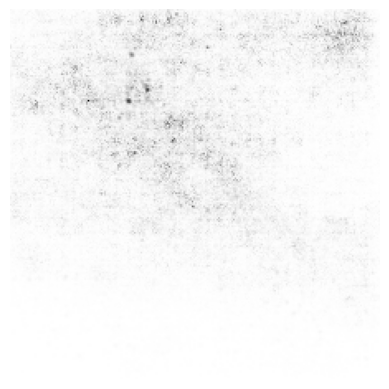

In [ ]:
# Method: Vanilla Gradient
img.requires_grad = True # make sure that gradient computation for the input is active
output = model(img)
prediction = output.argmax(dim=1) # 232 = Border collie
prediction_output = torch.gather(output, 1, prediction.unsqueeze(-1)) # get output node at predicted index

gradients = torch.autograd.grad(prediction_output, img, create_graph=False)[0] # compute gradient

gradients_plot = gradients[0].abs().sum(dim=0).detach().cpu().numpy()
gradients_plot = gradients_plot / gradients_plot.max()

plt.imshow(gradients_plot, cmap='binary', vmin = 0, vmax = 1)
plt.axis('off')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

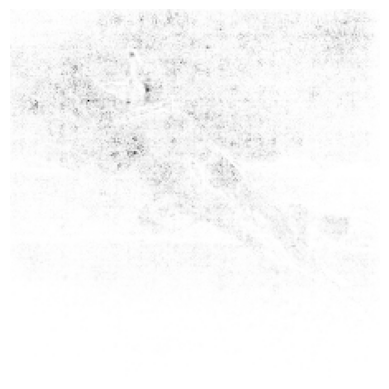

In [ ]:
# Input X Gradient
img.requires_grad = True # make sure that gradient computation for the input is active
output = model(img)
prediction = output.argmax(dim=1) # 232 = Border collie
prediction_output = torch.gather(output, 1, prediction.unsqueeze(-1)) # get output node at predicted index

gradients = torch.autograd.grad(prediction_output, img, create_graph=False)[0] # compute gradient
input_x_gradients = gradients * img

gradients_plot = input_x_gradients[0].abs().sum(dim=0).detach().cpu().numpy()
gradients_plot = gradients_plot / gradients_plot.max()

plt.imshow(gradients_plot, cmap='binary', vmin = 0, vmax = 1)
plt.axis('off')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

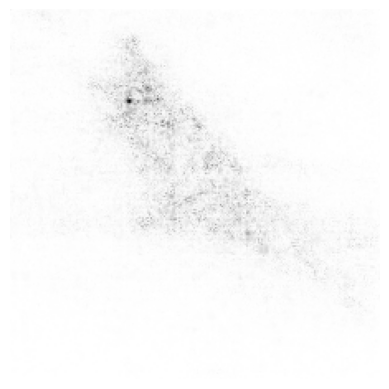

In [ ]:
# Method: SmootGrad
all_gradients = []

for i in range(50):
  img_noisy = img.clone() + 0.15*torch.randn_like(img) # add Gaussian noise
  img_noisy = img_noisy.detach() # make it a leaf variable
  img_noisy.requires_grad = True # make sure that gradient computation for the input is active
  output = model(img_noisy)
  prediction_output = torch.gather(output, 1, torch.tensor([232]).to('cuda:0').unsqueeze(-1)) # get output node at predicted index

  gradients = torch.autograd.grad(prediction_output, img_noisy, create_graph=False)[0] # compute gradient
  all_gradients.append(gradients.detach())

gradients = torch.concat(all_gradients,dim=0).mean(dim=0, keepdim=True)
gradients_plot = gradients[0].abs().sum(dim=0).detach().cpu().numpy()
gradients_plot = gradients_plot / gradients_plot.max()

plt.imshow(gradients_plot, cmap='binary', vmin = 0, vmax = 1)
plt.axis('off')

Shape activation last layer: torch.Size([1, 2048, 7, 7])
Shape gradients last layer: torch.Size([1, 2048, 7, 7])
Shape gradients last layer after GAP: torch.Size([1, 2048, 1, 1])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

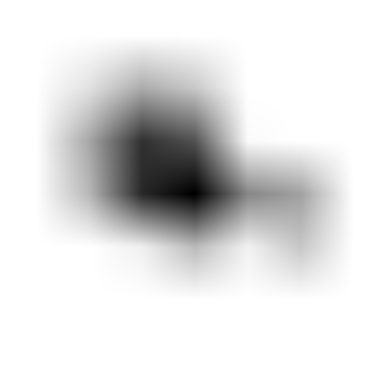

In [ ]:
# Method: Grad-CAM
# forward and backward hooks
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

gradient = {}
def get_gradient(name):
    def hook(model, input, output):
        gradient[name] = output[0].detach()
    return hook

# register hooks at last layer
model.layer4[2].conv3.register_forward_hook(get_activation('last_layer'))
model.layer4[2].conv3.register_backward_hook(get_gradient('last_layer'))

# forward pass
img.requires_grad = True
output = model(img)
activation_last_layer = activation['last_layer']
print('Shape activation last layer:', activation_last_layer.shape)

# backward pass
prediction = output.argmax(dim=1) # 232 = Border collie
prediction_output = torch.gather(output, 1, prediction.unsqueeze(-1)) # get output node at predicted index
gradients_input = torch.autograd.grad(prediction_output, img, create_graph=False)[0] # compute gradient
gradients_last_layer = gradient['last_layer']
print('Shape gradients last layer:', gradients_last_layer.shape)

# global average pooling
gradients_last_layer = gradients_last_layer.mean(-1).mean(-1).unsqueeze(-1).unsqueeze(-1)
print('Shape gradients last layer after GAP:', gradients_last_layer.shape)

# Grad-CAM
weighted_activation = activation_last_layer * gradients_last_layer
grad_cam = torch.nn.functional.relu(weighted_activation.sum(dim=1, keepdim=True))
up = torch.nn.Upsample(scale_factor=32, mode='bilinear')
grad_cam = up(grad_cam)

gradients_plot = grad_cam[0].abs().sum(dim=0).detach().cpu().numpy()
gradients_plot = gradients_plot / gradients_plot.max()

plt.imshow(gradients_plot, cmap='binary', vmin = 0, vmax = 1)
plt.axis('off')

100%|██████████| 1500/1500 [00:22<00:00, 65.82it/s]

Explanation and amount to explain match:
tensor(5.6784, device='cuda:0', grad_fn=<SumBackward0>)
tensor(5.5641, device='cuda:0', grad_fn=<SubBackward0>)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

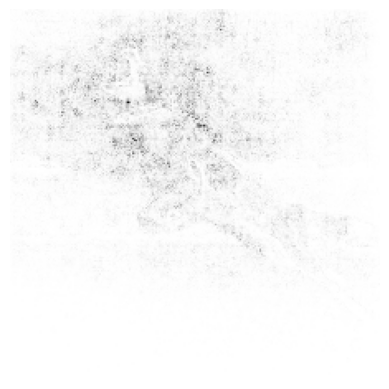

In [ ]:
# Method: Integrated Gradients
all_gradients = []

interpolation_constants = np.linspace(0, 1.0, num=1500) # these are our alphas to interpolate between baseline and image of interest (lecture num=1500)
baseline = torch.zeros_like(img) # the zero baseline (zeros_like copies shape and device)

for alpha in tqdm(interpolation_constants):
  img_interpolated = img.clone()
  img_interpolated = alpha*img_interpolated + (1.-alpha)*baseline # create interpolated image
  img_interpolated = img_interpolated.detach() # make it a leaf variable (in the computational graph of PyTorch)
  img_interpolated.requires_grad = True # make sure that gradient computation for the input is active (in regular DNN training we don't need the gradients of the input but just of the layers in the DNN)

  output = model(img_interpolated) # forward pass
  prediction_output = torch.gather(output, 1, torch.tensor([232]).to('cuda:0').unsqueeze(-1)) # get output node at predicted index; again 232 hardcoded because the model could predict different classes for the interpolated image

  gradients = torch.autograd.grad(prediction_output, img_interpolated, create_graph=False)[0] # compute gradient
  all_gradients.append(gradients.detach()) # here the gradients are collected

gradients = torch.concat(all_gradients,dim=0).mean(dim=0, keepdim=True) # concat all gradients along the batch dimension (1500, 3, 224, 224) and compute average over batch dimension (Riemann Integral)

integrated_gradients = img * gradients # according to formula we compute input - baseline times the integral. Zero baseline --> just take input

# Integrated Gradients satisfies completeness, ie, the output of the class of interest minus the output for the baseline for that class equals the attribution sum
# We need to set the interpolation steps quite high (=1500) to get a good approximation for the current model + image. Usually 50 to 300 iterations should be sufficient.
print('Explanation and amount to explain match:') # these two outputs should be similar
print(integrated_gradients.sum()) # attribution sum
print(model(img_interpolated)[0,232] - model(baseline)[0,232]) # the output of the class of interest minus the output for the baseline for that class

gradients_plot = integrated_gradients[0].abs().sum(dim=0).detach().cpu().numpy() # visualize attribution map
gradients_plot = gradients_plot / gradients_plot.max()

plt.imshow(gradients_plot, cmap='binary', vmin = 0, vmax = 1)
plt.axis('off')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

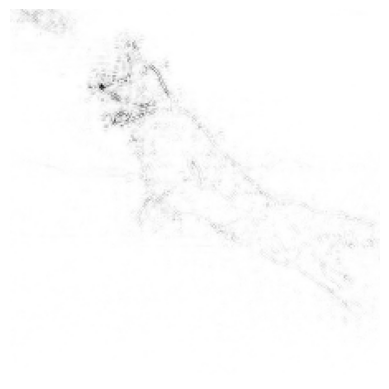

In [ ]:
# Method: Guided Backpropagation
class GuidedReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input) # Save input for backward pass
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = None
        input, = ctx.saved_tensors
        if ctx.needs_input_grad[0]:
            # Only propagate positive gradients through positive activations
            grad_input = grad_output.clamp(min=0) * (input > 0).float()
        return grad_input

# Wrapper for GuidedReLU
class GuidedReLUModule(nn.Module):
    def forward(self, input):
        return GuidedReLU.apply(input)

# Register the modified ReLU
def register_guided_relu(model):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.ReLU):
            # Replace the ReLU module with the GuidedReLUModule instance
            setattr(model, name, GuidedReLUModule())
        else:
            register_guided_relu(module)

# Create a copy of the model and register the guided ReLU
guided_model = resnet50(weights=ResNet50_Weights.DEFAULT)
guided_model = guided_model.to('cuda:0')
guided_model.eval()
register_guided_relu(guided_model)

# forward and backward pass with the guided model
# Ensure img has requires_grad=True before the forward pass
img.requires_grad = True
output = guided_model(img)
prediction = output.argmax(dim=1)
prediction_output = torch.gather(output, 1, prediction.unsqueeze(-1))

# Ensure that the graph is being created for gradient computation on the input
guided_gradients = torch.autograd.grad(prediction_output, img, create_graph=False)[0]

gradients_plot = guided_gradients[0].abs().sum(dim=0).detach().cpu().numpy()
gradients_plot = gradients_plot / gradients_plot.max()

plt.imshow(gradients_plot, cmap='binary', vmin = 0, vmax = 1)
plt.axis('off')